In [1]:
import json
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch_geometric import nn as geo_nn
from sklearn.metrics import roc_auc_score
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.nn import functional as F
from torch_scatter import scatter_mean

In [13]:
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
seq_matrix = pd.read_csv("data/FINAL_SEQUENCES_MATRIX.csv", sep='\t')

In [33]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

test_ids  = target_traintest[target_traintest["TARGET"] == "test"]["CLIENT_ID"].values
train_ids = target_traintest[target_traintest["TARGET"] != "test"]["CLIENT_ID"].values

In [34]:
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')

train_target_features = pd.merge(target_traintest[target_traintest["TARGET"] != "test"], features_traintest, 
                                 left_on="CLIENT_ID", right_on="CLIENT_ID")
train_target_features.fillna(0, inplace=True)
train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)
train_target_features.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1026390,20210501,1,0.0,0.0,255.0,0.0,17.0,0.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## GAT

In [28]:
from torch_geometric.data import Data
from torch_geometric.transforms import ToUndirected

to_und = ToUndirected()

def make_data(x):
    fr_feat = features_friends[features_friends["CLIENT_ID"] == x["CLIENT_ID"]]
    num_friends = fr_feat.shape[0]
    edge_index = np.hstack([np.arange(1, num_friends + 1)[:, None], np.zeros(shape=[num_friends, 1], dtype=np.int64)])
    y = x["TARGET"]
    res = Data(x=torch.from_numpy(np.concatenate([np.array(x.drop(["CLIENT_ID", "RETRO_DT", "TARGET"]))[None, :], 
                                                    np.array(fr_feat.drop(["CLIENT_ID", "FRIEND_ID"], axis=1))])), 
               edge_index=torch.from_numpy(edge_index).T,
               y=y,
               client_id = x["CLIENT_ID"])
    res = to_und(res)
    return res

friends_dataset = train_target_features.apply(lambda x: make_data(x), axis=1)
friends_dataset.sample(10)

61221    [(x, [tensor([0., 0., 0.,  ..., 0., 0., 0.], d...
33134    [(x, [tensor([  0.,   4., 467.,  ...,   0.,   ...
54375    [(x, [tensor([  0.,   1., 720.,  ...,   0.,   ...
53613    [(x, [tensor([   0.,    0., 1217.,  ...,    0....
50411    [(x, [tensor([ 0.,  0., 15.,  ...,  0.,  0.,  ...
78383    [(x, [tensor([0., 0., 0.,  ..., 0., 0., 0.], d...
14471    [(x, [tensor([  0.,   0., 580.,  ...,   0.,   ...
27327    [(x, [tensor([ 0.,  0., 17.,  ...,  0.,  0.,  ...
52440    [(x, [tensor([ 0.,  1., 56.,  ...,  0.,  0.,  ...
2189     [(x, [tensor([0., 0., 3.,  ..., 0., 0., 0.], d...
dtype: object

In [30]:
mask = np.random.choice(friends_dataset.shape[0], size=friends_dataset.shape[0], replace=False)
ratio = int(0.8 * len(mask))
train_dataset, val_dataset = friends_dataset[mask[:ratio]].values, friends_dataset[mask[ratio:]].values

In [32]:
torch.save(train_dataset, "data/processed/train_dataset.pt")
torch.save(val_dataset, "data/processed/val_dataset.pt")
#torch.save(test_dataset, "data/processed/test_dataset.pt")

In [67]:
from torch_geometric.loader import DataLoader

dataloaders = {"train": DataLoader(train_dataset, batch_size=10_000),
               "val": DataLoader(val_dataset, batch_size=1000)}

In [73]:
class NodeEncoder(Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = Linear(in_features, in_features)
        self.gat = GATv2Conv(in_channels=in_features, 
                       hidden_channels=hid_features, 
                       out_channels=hid_features,
                       num_layers=1)
        self.linear_out = Linear(hid_features, out_features)
        
    def forward(self, data):
        x, edges = data.x, data.edge_index
        x = self.gat(relu(self.linear_in(x.float())), edges, )
        x = self.linear_out(relu(x))
        return softmax(scatter_mean(x, data.batch, dim=0), dim=1)

node_encoder = NodeEncoder(features_traintest.shape[1]-1, 512, 2)

In [74]:
for i in dataloaders["train"]:
    res = node_encoder(i)
    print(res.shape)
    break

torch.Size([10000, 2])


In [75]:
i.y.int()

tensor([0, 1, 1,  ..., 0, 0, 1], dtype=torch.int32)

In [76]:
res

tensor([[1.0000e+00, 9.6783e-23],
        [0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        ...,
        [0.0000e+00, 1.0000e+00],
        [5.0094e-01, 4.9906e-01],
        [6.7523e-29, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [72]:
class_weights = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].values.astype(int).mean()
class_weights = torch.FloatTensor([class_weights, 1-class_weights])
class_weights

tensor([0.2742, 0.7258])

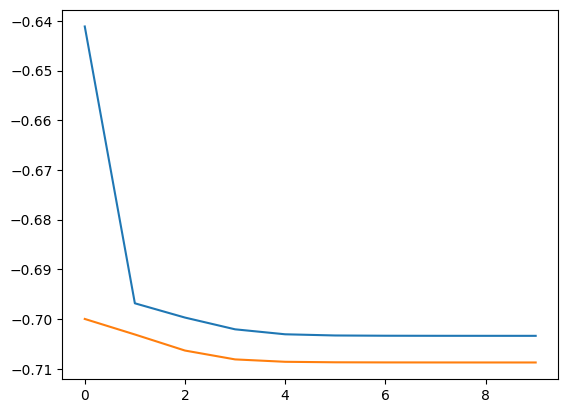

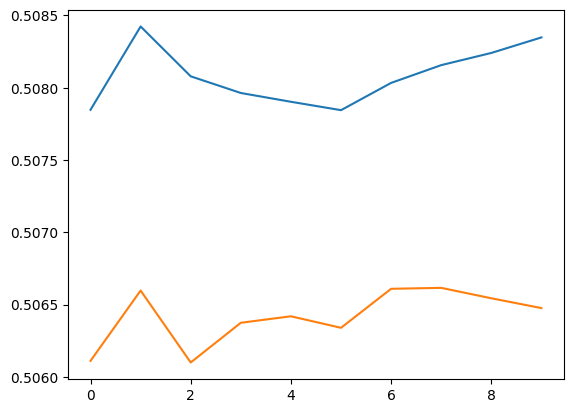

KeyboardInterrupt: 

In [77]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt


def train(model, dataloaders, epochs=100, class_weights=None, verbose=False, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        roc_aucs = []
        losses = []
        model.train()
        for data in dataloaders["train"]:
            optimizer.zero_grad()
            out = model(data)
            l = loss(out, data.y.long())
            losses.append(l.item())
            l.backward()
            optimizer.step()
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["train"].append(np.mean(roc_aucs))
        loss_history["train"].append(np.mean(losses))
        
        roc_aucs = []
        losses = []
        model.eval()
        for data in dataloaders["val"]:
            out = model(data)
            l = loss(out, data.y.long())
            losses.append(l.item())
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["val"].append(np.mean(roc_aucs))
        loss_history["val"].append(np.mean(losses))
        
        clear_output(wait=True)
        
        plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
        plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
        plt.show()
        
        plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
        plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
        plt.show()
    return score
score = train(node_encoder, dataloaders)

## Пробуем просто линейный + конкатенация

In [4]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

#test_ids  = target_traintest[target_traintest["TARGET"] == "test"]["CLIENT_ID"].values
#train_ids = target_traintest[target_traintest["TARGET"] != "test"]["CLIENT_ID"].values
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')

#target_features = pd.merge(target_traintest, features_traintest, 
#                                 left_on="CLIENT_ID", right_on="CLIENT_ID")
target_features.fillna(0, inplace=True)
test_target_features = target_features[target_features["TARGET"] == "test"].drop(["TARGET"], axis=1)
train_target_features = target_features[target_features["TARGET"] != "test"]
train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)
test_target_features.head()

/tmp/ipykernel_1070/3706286511.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)


,CLIENT_ID,RETRO_DT,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
4,1025140,20210501,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1029732,20210501,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1079794,20210501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1116331,20210501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1136822,20210501,0.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')

# ЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫЫы

In [ ]:
def make_data(x):
    friend_embedding = x.mean(axis=0)
    num_friends = x.shape[0]
    usr_features = pd.merge(friend_embedding.to_frame().T, features_traintest, how="left",
                            left_on="CLIENT_ID", right_on="CLIENT_ID")
    return usr_features.drop(["FRIEND_ID"], axis=1).reset_index(drop=True)

friends_dataset = features_friends.groupby(["CLIENT_ID"]).apply(lambda x: make_data(x))
print("ы")
friends_dataset.to_csv("data/friends_user_embeddings.csv")
#friends_dataset = features_traintest.apply(lambda x: make_data(x), axis=1)
#test_friends_dataset = test_target_features.apply(lambda x: make_data(x), axis=1)
#targets = train_target_features["TARGET"].values

#friends_dataset[0].shape
#friends_dataset.to_csv("data/)

In [101]:
class FriendsEmbedder(torch.nn.Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = nn.Linear(in_features, hid_features)
        self.linear_out = nn.Linear(hid_features, out_features)
    
    def forward(self, x):
        x_hid = F.relu(self.linear_in(x))
        x_out = self.linear_out(x_hid)
        return F.softmax(x_out, dim=1)
friend_embedder = FriendsEmbedder(friends_dataset[0].shape[0], 512, 2)

In [102]:
mask = np.random.choice(friends_dataset.shape[0], size=friends_dataset.shape[0], replace=False)
ratio = int(0.8 * len(mask))
X_train, X_val = np.vstack(friends_dataset[mask[:ratio]].values), np.vstack(friends_dataset[mask[ratio:]].values)
y_train, y_val = targets[mask[:ratio]], targets[mask[ratio:]]

In [103]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [104]:
class_weights = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].values.astype(int).mean()
class_weights = torch.FloatTensor([class_weights, 1-class_weights])
class_weights

tensor([0.2742, 0.7258])

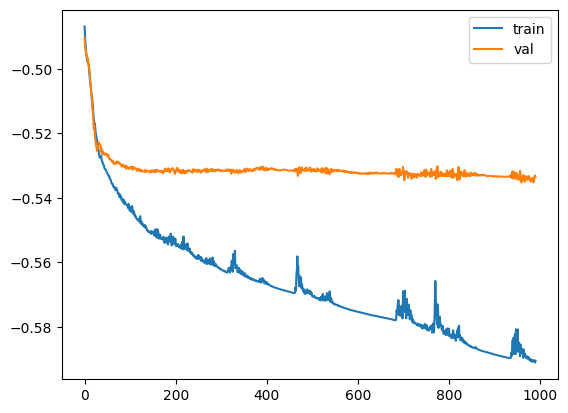

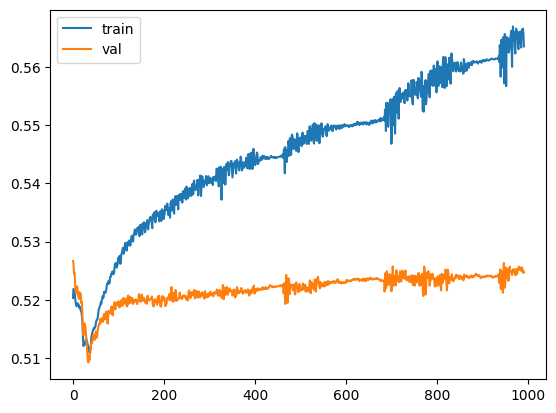

In [105]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

def predict(model, X, y, loss):
    out = model(X)
    l = loss(out, y)
    return l, roc_auc_score(y, out[:, 1].detach())

def train(model, X_train, y_train, X_val, y_val, epochs=100, class_weights=None, verbose=False, lr=3e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()
        l, auc = predict(model, X_train, y_train, loss)
        loss_history["train"].append(l.item())
        auc_history["train"].append(auc)
        l.backward()
        optimizer.step()
        
        model.eval()
        l, auc = predict(model, X_val, y_val, loss)
        loss_history["val"].append(l.item())
        auc_history["val"].append(auc)
        
        if ep % 10 == 0:
            clear_output(wait=True)
            plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
            plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
            plt.legend()
            plt.show()

            plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
            plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
            plt.legend()
            plt.show()
train(friend_embedder, X_train, y_train, X_val, y_val, 
      class_weights=class_weights, epochs=1000)

In [106]:
friend_embedder(X_val).mean(axis=0), y_val.float().mean()

(tensor([0.2898, 0.7102], grad_fn=<MeanBackward1>), tensor(0.2951))

In [ ]:
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
seq_matrix = pd.read_csv("data/FINAL_SEQUENCES_MATRIX.csv", sep='\t')

## Word2Vec

In [6]:
from gensim.models import Word2Vec

In [20]:
def get_sentences(name, column):
    sentences = pd.read_csv(name, sep='\t')
    sentences = sentences[column].apply(lambda x: json.loads(x.replace("'", '"')))
    return sentences

sentences_mat = get_sentences("data/FINAL_SEQUENCES_MATRIX.csv", "SESSIONS_SEQUENCES")
sentences_all = get_sentences("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", "SEQUENCE")
sentences = np.concatenate([sentences_mat, sentences_all])
sentences.shape[0] == sentences_mat.shape[0] + sentences_all.shape[0]

True

In [21]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=1, workers=4)
model.save("data/word2vec.model")

In [12]:
model = Word2Vec.load("data/word2vec.model")
model.train(sentences, total_examples=sentences.shape[0], epochs=5)

(47786993, 88901005)

In [22]:
for word in json.loads(all_seq_traintest.loc[0]["SEQUENCE"].replace("'", '"')):
    print(model.wv[word].shape)

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)


In [25]:
example = [model.wv[word] for word in json.loads(all_seq_traintest.loc[0]["SEQUENCE"].replace("'", '"'))]
example = np.vstack(example)
example.shape

(71, 200)

In [43]:
# Сразу выделим train/test части

target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

test_ids  = target_traintest[target_traintest["TARGET"] == "test"].index
train_ids = target_traintest[target_traintest["TARGET"] != "test"].index
test_ids

Int64Index([     4,      8,     18,     23,     27,     28,     29,     30,
                38,     43,
            ...
            159243, 159250, 159251, 159253, 159257, 159263, 159276, 159278,
            159284, 159288],
           dtype='int64', length=31858)

In [78]:
from torch_geometric.data import Data

def collect_graph(row):
    sequence = json.loads(row['SEQUENCE'].replace("'", '"'))
    if sequence == []:
        return Data(x=torch.FloatTensor(), edge_index=torch.FloatTensor(), y=torch.LongTensor(int(row["TARGET"])))
    x = torch.from_numpy(np.vstack([model.wv[word] for word in sequence]))
    nodes = list(set(sequence))
    edge_index = torch.IntTensor([[nodes.index(sequence[i]), nodes.index(sequence[i+1])] for i in range(len(nodes)-1)]).T
    return Data(x=x, edge_index=edge_index, y=torch.LongTensor(int(row["TARGET"])))
new_df = pd.merge(target_traintest.iloc[train_ids], all_seq_traintest, on="CLIENT_ID").apply(lambda x: collect_graph(x), axis=1)
new_df

0        [(x, [tensor([ 0.1860,  1.3867, -1.5953,  1.70...
1        [(x, [tensor([-0.0156,  1.1201,  0.8188,  0.59...
2        [(x, [tensor([-3.6969e-02,  7.6490e-01,  2.171...
3        [(x, [tensor([-5.8542e-02,  1.6408e+00, -1.011...
4        [(x, [tensor([ 0.1315,  0.3126,  0.7061, -0.51...
                               ...                        
98938    [(x, [tensor([ 0.5836, -0.1100,  1.1718,  0.11...
98939    [(x, [tensor([ 3.2160e-01, -4.5308e-01, -3.363...
98940    [(x, [tensor([ 2.1938e+00,  1.8171e+00, -3.633...
98941    [(x, [tensor([-0.7559,  0.6764,  0.5907, -0.55...
98942    [(x, [tensor([ 1.6228,  0.0836,  0.1474,  0.42...
Length: 98943, dtype: object

In [46]:
new_df['TARGET'] = new_df.apply(lambda x: x.y[0])

Data(x=[163, 200], edge_index=[2, 76], y=[0])

In [79]:
new_df[0].edge_index.dtype

torch.int32

In [80]:
i.edge_index

tensor([[9.0000e+00, 3.0000e+00, 9.0000e+00,  ..., 1.4037e+06, 1.4037e+06,
         1.4037e+06],
        [3.0000e+00, 9.0000e+00, 4.0000e+00,  ..., 1.4037e+06, 1.4037e+06,
         1.4037e+06]])

In [81]:
class GraphCollector(nn.Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = nn.Linear(in_features, in_features)
        self.gcn = geo_nn.GCNConv(in_features, hid_features)
        self.linear_out = nn.Linear(hid_features, out_features)
    
    def forward(self, x, edge_index, batch=None):
        x_hid = F.relu(self.linear_in(x))
        x_hid = F.relu(self.gcn(x, edge_index))
        x_out = F.relu(self.linear_out(x_hid))
        if batch is not None:
            return F.softmax(scatter_mean(x_out, batch, dim=0), dim=1)
        else:
            return F.softmax(x_out, dim=1)

gnn = GraphCollector(200, 100, 2)

In [87]:
from torch_geometric.loader import DataLoader
mask = np.random.choice(new_df.shape[0], size=new_df.shape[0], replace=False)
ratio = int(0.8 * len(mask))
dataloaders = {"train": DataLoader(new_df[mask[:ratio]].values, batch_size=10_000),
                "val": DataLoader(new_df[mask[ratio:]].values, batch_size=10_000)}
#X_train, X_val = np.vstack(new_df[mask[:ratio]].values), np.vstack(new_df[mask[ratio:]].values)
#y_train, y_val = targets[mask[:ratio]], targets[mask[ratio:]]

In [88]:
i.edge_index.dtype

torch.float32

In [89]:
for i in dataloaders["train"]:
    out = gnn(i.x, i.edge_index, i.batch)
    print(i, out.shape)

KeyError: 9

In [60]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

def predict(model, X, y, loss):
    out = model(X)
    l = loss(out, y)
    return l, roc_auc_score(y, out[:, 1].detach())

def train(model, dataloaders, epochs=100, class_weights=None, verbose=False, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        roc_aucs = []
        losses = []
        model.train()
        for data in dataloaders["train"]:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            print(out.shape, data.y.shape)
            l = loss(out, data.y.long())
            losses.append(l.item())
            l.backward()
            optimizer.step()
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["train"].append(np.mean(roc_aucs))
        loss_history["train"].append(np.mean(losses))
        
        roc_aucs = []
        losses = []
        model.eval()
        for data in dataloaders["val"]:
            out = model(data.x, data.edge_index)
            l = loss(out, data.y.long())
            losses.append(l.item())
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["val"].append(np.mean(roc_aucs))
        loss_history["val"].append(np.mean(losses))
        
        clear_output(wait=True)
        
        plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
        plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
        plt.show()
        
        plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
        plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
        plt.show()
    return score
score = train(gnn, dataloaders)

torch.Size([114, 2]) torch.Size([0])


ValueError: Expected input batch_size (114) to match target batch_size (0).